## TEAM CHALLENGE: TOOLBOX

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, f_oneway, kruskal


In [2]:
# Cargar dataset Titanic
df = pd.read_csv("./data/titanic.csv")


In [3]:
df.head()

,sex,age,sibsp,parch,fare,class,who,adult_male,embark_town,alive,alone
0,male,22.0,1,0,7.2500,Third,man,True,Southampton,no,False
1,female,38.0,1,0,71.2833,First,woman,False,Cherbourg,yes,False
2,female,26.0,0,0,7.9250,Third,woman,False,Southampton,yes,True
3,female,35.0,1,0,53.1000,First,woman,False,Southampton,yes,False
4,male,35.0,0,0,8.0500,Third,man,True,Southampton,no,True


In [4]:
# Función: describe_df

def describe_df(df):
    """
    Genera un resumen del DataFrame mostrando, para cada variable:
    - Tipo de dato
    - Porcentaje de valores nulos
    - Número de valores únicos
    - Porcentaje de cardinalidad

    Argumentos:
    df (pd.DataFrame): DataFrame a analizar.

    Retorna:
    pd.DataFrame: DataFrame con una columna por variable
    y filas correspondientes a métricas descriptivas.
    """

    if not isinstance(df, pd.DataFrame):
        print("Error: df no es un DataFrame.")
        return None

    resumen = pd.DataFrame({
        "DATA_TYPE": df.dtypes,
        "MISSING(%)": df.isnull().mean() * 100,
        "UNIQUE_VALUES": df.nunique(),
        "CARDIN (%)": df.nunique() / len(df) * 100
    }).T

    return resumen


In [5]:
describe_df(df)


,sex,age,sibsp,parch,fare,class,who,adult_male,embark_town,alive,alone
DATA_TYPE,object,float64,int64,int64,float64,object,object,bool,object,object,bool
MISSING(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,2,89,7,7,248,3,3,2,3,2,2
CARDIN (%),0.224467,9.988777,0.785634,0.785634,27.833895,0.3367,0.3367,0.224467,0.3367,0.224467,0.224467


In [6]:
# Función: tipifica_variables

def tipifica_variables(df, umbral_categoria, umbral_continua):
    """
    Sugiere el tipo de cada variable de un DataFrame.

    Argumentos:
    df (pd.DataFrame): DataFrame de entrada.
    umbral_categoria (int): Umbral de cardinalidad.
    umbral_continua (float): Umbral % para variables continuas.

    Retorna:
    pd.DataFrame: nombre_variable, tipo_sugerido
    """

    if not isinstance(df, pd.DataFrame):
        print("Error: df no es un DataFrame.")
        return None

    if not isinstance(umbral_categoria, int) or umbral_categoria <= 0:
        print("Error: umbral_categoria incorrecto.")
        return None

    if not isinstance(umbral_continua, float) or not (0 < umbral_continua <= 100):
        print("Error: umbral_continua incorrecto.")
        return None

    resultados = []
    n_filas = len(df)

    for col in df.columns:
        cardinalidad = df[col].nunique()
        pct_card = cardinalidad / n_filas * 100

        if cardinalidad == 2:
            tipo = "Binaria"
        elif cardinalidad < umbral_categoria:
            tipo = "Categórica"
        else:
            if pct_card >= umbral_continua:
                tipo = "Numerica Continua"
            else:
                tipo = "Numerica Discreta"

        resultados.append({
            "nombre_variable": col,
            "tipo_sugerido": tipo
        })

    return pd.DataFrame(resultados)


In [7]:
tipifica_variables(df, umbral_categoria=10, umbral_continua=30.0)


,nombre_variable,tipo_sugerido
0,sex,Binaria
1,age,Numerica Discreta
2,sibsp,Categórica
3,parch,Categórica
4,fare,Numerica Discreta
5,class,Categórica
6,who,Categórica
7,adult_male,Binaria
8,embark_town,Categórica
9,alive,Binaria


In [8]:
# Función: get_features_num_regression

def get_features_num_regression(df, target_col, umbral_corr, pvalue=None):
    """
    Selecciona variables numéricas con alta correlación con un target.

    Argumentos:
    df (pd.DataFrame)
    target_col (str)
    umbral_corr (float)
    pvalue (float o None)

    Retorna:
    list
    """

    if not isinstance(df, pd.DataFrame):
        print("Error: df no es DataFrame.")
        return None

    if target_col not in df.columns:
        print("Error: target_col no existe.")
        return None

    if not np.issubdtype(df[target_col].dtype, np.number):
        print("Error: target_col no es numérica.")
        return None

    if not isinstance(umbral_corr, float) or not (0 <= umbral_corr <= 1):
        print("Error: umbral_corr incorrecto.")
        return None

    if pvalue is not None:
        if not isinstance(pvalue, float) or not (0 < pvalue < 1):
            print("Error: pvalue incorrecto.")
            return None

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    numeric_cols.remove(target_col)

    y = df[target_col]
    selected_features = []

    for col in numeric_cols:
        data = df[[col, target_col]].dropna()
        if len(data) < 2:
            continue

        corr, p_val = pearsonr(data[col], data[target_col])

        if abs(corr) >= umbral_corr:
            if pvalue is None or p_val <= pvalue:
                selected_features.append(col)

    return selected_features


In [9]:
get_features_num_regression(df, "fare", umbral_corr=0.2, pvalue=0.05)


['parch']

In [10]:
#Función: plot_features_num_regression

def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    """
    Genera pairplots entre target y variables numéricas relevantes.

    Retorna:
    list
    """

    if target_col == "" or target_col not in df.columns:
        print("Error: target_col no válido.")
        return None

    if columns == []:
        columns = df.select_dtypes(include=np.number).columns.tolist()
        columns.remove(target_col)

    valid_cols = []

    for col in columns:
        data = df[[col, target_col]].dropna()
        corr, p_val = pearsonr(data[col], data[target_col])

        if abs(corr) >= umbral_corr:
            if pvalue is None or p_val <= pvalue:
                valid_cols.append(col)

    # Pintar máximo 5 variables por gráfico
    for i in range(0, len(valid_cols), 4):
        subset = valid_cols[i:i+4]
        sns.pairplot(df[[target_col] + subset])
        plt.show()

    return valid_cols


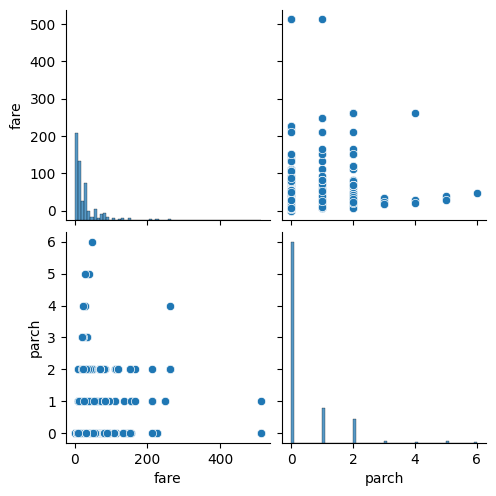

['parch']

In [11]:
plot_features_num_regression(df, target_col="fare", umbral_corr=0.2, pvalue=0.05)


In [12]:
#Función:get_features_cat_regression

def get_features_cat_regression(df, target_col, pvalue=0.05):
    """
    Selecciona variables categóricas relacionadas con un target numérico.
    """

    if not np.issubdtype(df[target_col].dtype, np.number):
        print("Error: target_col no es numérico.")
        return None

    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    selected = []

    for col in cat_cols:
        groups = [df[df[col] == val][target_col].dropna() for val in df[col].dropna().unique()]
        if len(groups) < 2:
            continue

        stat, p = f_oneway(*groups) if len(groups) <= 10 else kruskal(*groups)

        if p <= pvalue:
            selected.append(col)

    return selected


In [13]:
get_features_cat_regression(df, "fare")


['sex', 'class', 'who', 'embark_town', 'alive']

In [14]:
# Función: plot_features_cat_regression

def plot_features_cat_regression(df, target_col="", columns=[], pvalue=0.05, with_individual_plot=False):
    """
    Genera histogramas del target según variables categóricas.
    """

    if target_col == "" or not np.issubdtype(df[target_col].dtype, np.number):
        print("Error: target_col inválido.")
        return None

    if columns == []:
        columns = df.select_dtypes(include=["object", "category"]).columns.tolist()

    valid_cols = []

    for col in columns:
        groups = [df[df[col] == val][target_col].dropna() for val in df[col].dropna().unique()]
        if len(groups) < 2:
            continue

        stat, p = f_oneway(*groups) if len(groups) <= 10 else kruskal(*groups)

        if p <= pvalue:
            valid_cols.append(col)

            if with_individual_plot:
                sns.histplot(data=df, x=target_col, hue=col, kde=True)
                plt.show()

    return valid_cols


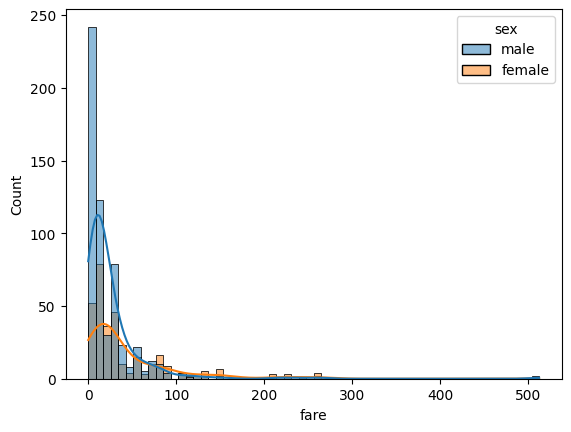

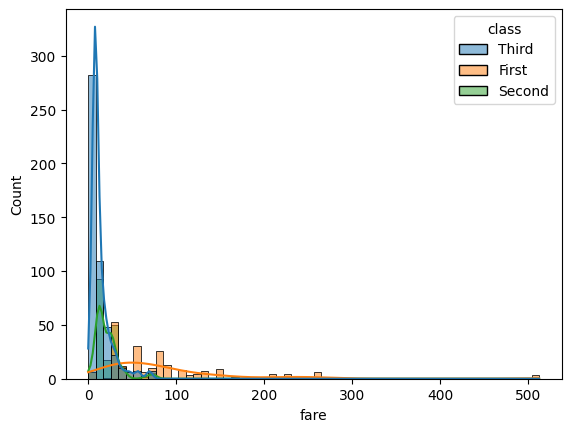

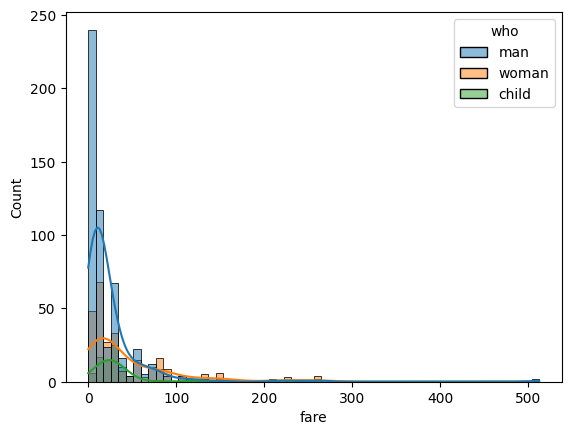

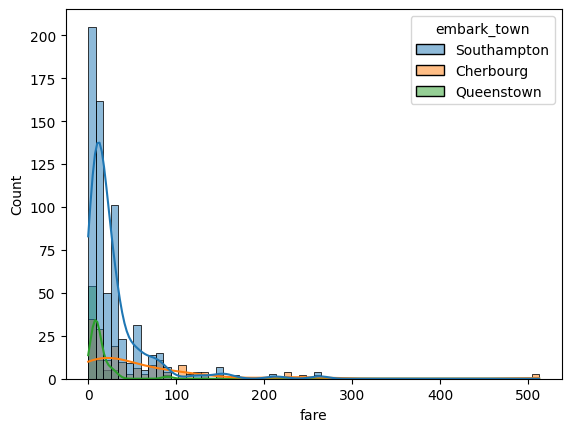

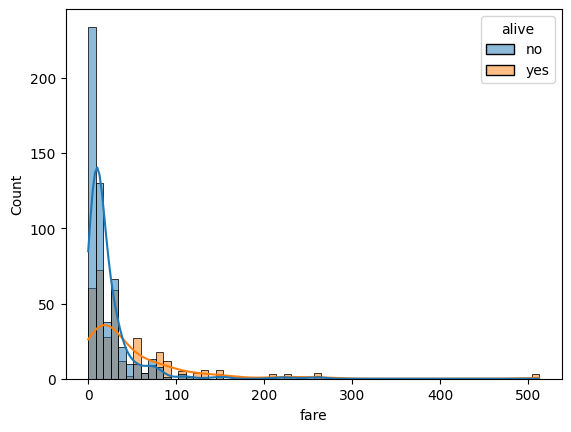

['sex', 'class', 'who', 'embark_town', 'alive']

In [15]:
plot_features_cat_regression(df, "fare", with_individual_plot=True)


### Visualización de variables categóricas

La función `plot_features_cat_regression` permite visualizar la relación
entre la variable objetivo `fare` y las variables categóricas
relevantes seleccionadas por `get_features_cat_regression`.

Los gráficos muestran:
- La distribución de `fare` según cada categoría de la variable.  
- La relación estadísticamente significativa con la variable objetivo.  
- La utilidad de estas variables para un posible modelo de regresión.

En este ejemplo, solo se muestran las variables categóricas que
cumplen el criterio de significación establecido (pvalue=0.05).
